In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load and preprocess data
X = np.load('X_keypoints.npy')  # Shape: (samples, 40, 66)
y = np.load('y_labels.npy')

# Normalize features
scaler = StandardScaler()
X_reshaped = X.reshape(-1, X.shape[2])
X_scaled = scaler.fit_transform(X_reshaped).reshape(X.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

def create_vit_model():
    inputs = layers.Input(shape=(40, 66))
    
    # 1. Temporal Patching and Embedding
    x = layers.Dense(128)(inputs)  # Project raw features to transformer dimension
    
    # 2. Positional Encoding
    positions = tf.range(start=0, limit=40, delta=1)
    positional_encoding = layers.Embedding(
        input_dim=40, 
        output_dim=128,
        embeddings_initializer="glorot_uniform"
    )(positions)
    positional_encoding = tf.expand_dims(positional_encoding, axis=0)  # [1, 40, 128]
    
    x = x + positional_encoding  # Add positional information
    
    # 3. Transformer Encoder
    for _ in range(4):  # 4 transformer blocks
        # Multi-head self-attention
        attn = layers.MultiHeadAttention(
            num_heads=8, 
            key_dim=16,  # 8 heads * 16 = 128
            dropout=0.1
        )(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn)
        
        # Feed-forward network
        ffn = layers.Dense(512, activation="gelu")(x)
        ffn = layers.Dropout(0.1)(ffn)
        ffn = layers.Dense(128)(ffn)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ffn)
    
    # 4. Classification Head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="gelu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    return Model(inputs, outputs)




In [28]:
# Create and compile model
model = create_vit_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name='auc')]
)

# Training configuration
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=15,
    mode='max',
    restore_best_weights=True
)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=6,
    validation_split=0.2,
    callbacks=[early_stop]
)

# Evaluation
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step - accuracy: 0.5333 - auc: 0.5213 - loss: 0.7712 - val_accuracy: 0.6667 - val_auc: 0.6389 - val_loss: 0.6537
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6981 - auc: 0.7661 - loss: 0.5925 - val_accuracy: 0.6111 - val_auc: 0.6736 - val_loss: 0.6869
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6002 - auc: 0.7166 - loss: 0.6170 - val_accuracy: 0.6111 - val_auc: 0.6389 - val_loss: 0.7020
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6667 - auc: 0.7593 - loss: 0.5541 - val_accuracy: 0.6667 - val_auc: 0.6389 - val_loss: 0.7116
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7317 - auc: 0.8420 - loss: 0.4919 - val_accuracy: 0.6111 - val_auc: 0.6389 - val_loss: 0.7070
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8033 - auc: 0.8936 - loss: 0.4287 - val_accuracy: 0.6111 - val_auc: 0.6528 - val_loss: 0.7050
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━

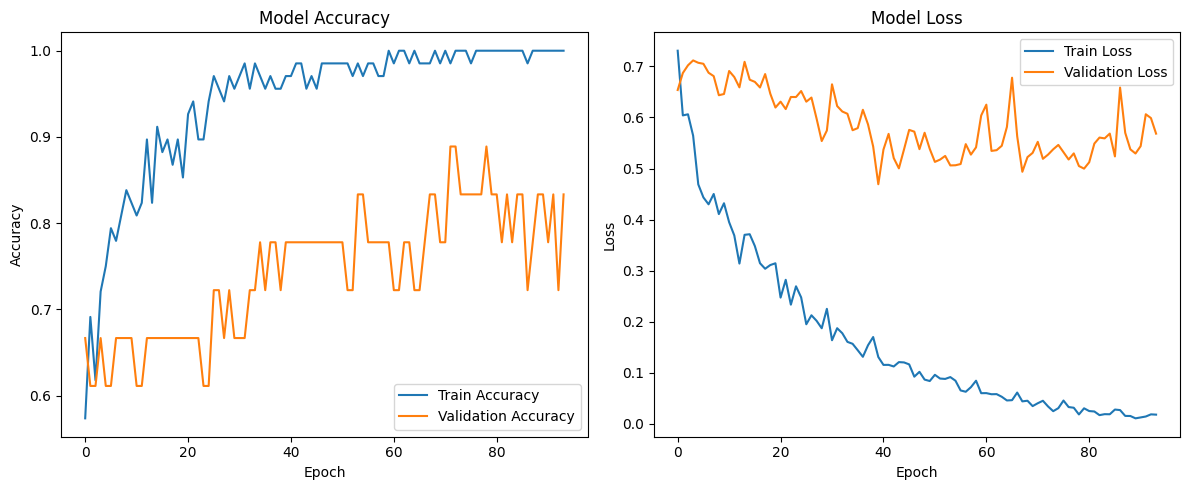

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


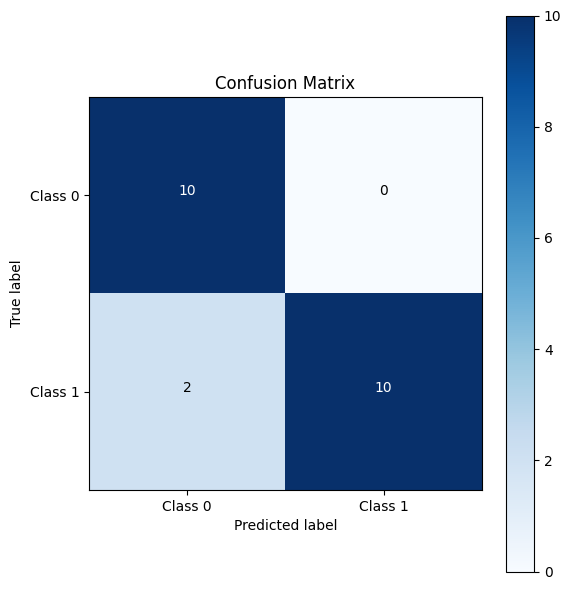


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.83      1.00      0.91        10
     Class 1       1.00      0.83      0.91        12

    accuracy                           0.91        22
   macro avg       0.92      0.92      0.91        22
weighted avg       0.92      0.91      0.91        22



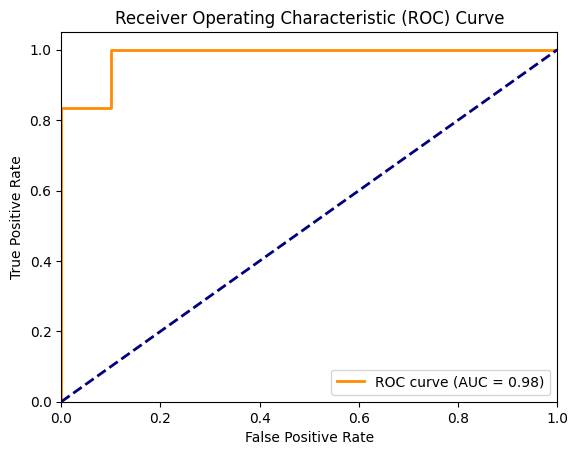

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9091 - auc: 0.9833 - loss: 0.2561
Test Accuracy: 0.9091
Test AUC: 0.9833


In [29]:

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# 2. Confusion Matrix and Classification Report
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = [0, 1]
plt.xticks(tick_marks, ["Class 0", "Class 1"])
plt.yticks(tick_marks, ["Class 0", "Class 1"])

thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class, target_names=["Class 0", "Class 1"]))

# 3. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 4. Final Metrics
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

In [31]:
def plot_vit_attention(model, sample, layer_idx=2, head_idx=0):
    # Create submodel to get attention weights
    multihead_attention_layer = model.layers[5]._layers[2].attention  # Adjust index based on your model
    partial_model = Model(
        inputs=model.input,
        outputs=multihead_attention_layer.output[1]  # Attention weights
    )
    
    # Get attention weights
    _, attention_weights = partial_model.predict(sample[np.newaxis, ...])
    
    # Average across heads or select specific head
    head_attention = attention_weights[0, head_idx]  # [num_heads, seq_len, seq_len]
    
    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(head_attention, cmap='viridis')
    plt.colorbar(label='Attention Strength')
    plt.title(f'ViT Attention Map (Layer {layer_idx}, Head {head_idx})')
    plt.xlabel('Target Frame')
    plt.ylabel('Source Frame')
    plt.show()

# Usage
plot_vit_attention(model, X_train)

IndexError: list index out of range